# Housing Sales Prices & Venues Data Analysis of Almaty

## 1. A description of the problem and a discussion of the background.

Almaty is the largest city in Kazakhstan, with a population of about 2.000.000 people (about 11% of the country's total population) and it has a population density of 2.636 people per square kilometer. As a resident of this city, I decided to use Almaty in my project. The city is divided into 8 districts in total. Almaty generates approximately 20 per cent of Kazakhstan's GDP. The nation is the most powerful economically in Central Asia and Almaty is a key financial center. The economy of Almaty city and Almaty Region continues to grow, and is expected to increase by nearly 6.5 percent per year. As you can see from the figures, Almaty is a city with a high population density and it has a big investment potential. 

From the investors point of view, we expect from them to prefer the districts where there is a lower real estate cost, high population density and the type of business they want to install is less intense. And from the city resident point of view, it's mostly valuable to chose districts where real estate values are lower and the social places density is high.

However, it is difficult to obtain information that will guide investors in this direction, nowadays. When we consider all these problems, we can create a map and information chart where the real estate index is placed on Almaty and each district is clustered according to the venue density.

## 2. A description of the data and how it will be used to solve the problem.

To solve the problem I will use below data:

 - I found the population of Almaty districts data from https://journals.openedition.org/belgeo/28865?lang=en, cleaned it and uploaded to Github repository
 - I used Forsquare API to get the most common venues of given Borough of Almaty.
 - There are not too many public datas related to demographic and social parameters for the city of Almaty. Therefor you must set-up your own data tables in most cases. In this case, I collected latest per square meter Housing Sales Price (HSP) Averages for each Borough of Almaty from housing retail web page (https://krisha.kz/content/analytics).
 - I used Google Map, ‘Search Nearby’ option to get the center coordinates of the each Borough.

## 3. Methodology section

importing libraries

In [1]:
import requests # for getting the HTML contents of the website
import lxml.html as lh # for parsing the relevant fields
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    ca-certificates-2020.6.20  |       hecda079_0         145 KB  conda-forge
    certifi-2020.6.20          |   py36h9f0ad1d_0         151 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.5 MB

The following NEW packages will be INSTALLED:

    geographiclib:   1.50-py_0          conda-forge
    geopy:           

### As a database, I used GitHub repository in my study. My master data which has the main components Borough, Average House square meter Price, Latitude and Longitude informations of the city:

In [146]:
url="https://raw.githubusercontent.com/alexstar-kz/Coursera_Capstone-IBM-Data-Science-/master/price%2Bpopulation"

In [147]:
price_df=pd.read_csv(url)

In [148]:
price_df

,Borough,Avg-House-SQR_M-Price-USD,Latitude,Longtitude,Population,Density-of-population-per-square_km
0,Alatau district,874,43.278479,76.849038,195348,11152
1,Almaly district,1048,43.252580,76.912461,204879,1877
2,Auezov district,929,43.229568,76.837504,277338,11754
3,Bostandyk district,1172,43.164182,76.929771,316020,3179
4,Medeu district,1337,43.147694,77.033535,188899,746
5,Nauryzbay district,841,43.172516,76.837540,91172,1308
6,Turksib district,778,43.339788,76.985542,209789,2783
7,Jetysu district,836,43.281011,76.952791,157999,4001


### I used python folium library to visualize geographic details of Istanbul and its boroughs and I created a map of Istanbul with boroughs superimposed on top. I used latitude and longitude values to get the visual as below:

using geopy library to get the latitude and longitude values of Almaty

In [149]:
address = 'Almaty, KZ'

geolocator = Nominatim(user_agent="on_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Almaty are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Almaty are 43.2363924, 76.9457275.


creating a map of Almaty with neighborhoods superimposed on top

In [150]:
# create map of Almaty using latitude and longitude values
map_almaty = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(price_df['Latitude'], price_df['Longtitude'], price_df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_almaty)  
    
map_almaty

### I utilized the Foursquare API to explore the boroughs and segment them. I designed the limit as 100 venue and the radius 3000 meter for each borough from their given latitude and longitude informations. Here is a head of the list Venues name, category, latitude and longitude informations from Forsquare API.

defining Foursquare credentials and version

In [151]:
CLIENT_ID = 'ICWVYFTHVNOFTYKJJ2Q4KGRDKOJLPBGUEJLCHOZWJJ0T25ND' # your Foursquare ID
CLIENT_SECRET = 'XFTDEMSSBLTYTLVJ252BDQNOV5MBMT2XB2BUNQEMNPFTI5NT' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ICWVYFTHVNOFTYKJJ2Q4KGRDKOJLPBGUEJLCHOZWJJ0T25ND
CLIENT_SECRET:XFTDEMSSBLTYTLVJ252BDQNOV5MBMT2XB2BUNQEMNPFTI5NT


exploring the first borough in our dataframe

In [152]:
price_df.loc[0, 'Borough']

'Alatau district'

In [153]:
borough_latitude = price_df.loc[0, 'Latitude'] # neighborhood latitude value
borough_longitude = price_df.loc[0, 'Longtitude'] # neighborhood longitude value

borough_name = price_df.loc[0, 'Borough'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(borough_name, 
                                                               borough_latitude, 
                                                               borough_longitude))


Latitude and longitude values of Alatau district are 43.278479, 76.84903800000001.


geting the top 100 venues that are in Parkwoods within a radius of 750 meters

In [154]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 3000 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    borough_latitude, 
    borough_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=ICWVYFTHVNOFTYKJJ2Q4KGRDKOJLPBGUEJLCHOZWJJ0T25ND&client_secret=XFTDEMSSBLTYTLVJ252BDQNOV5MBMT2XB2BUNQEMNPFTI5NT&v=20180605&ll=43.278479,76.84903800000001&radius=3000&limit=100'

In [155]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f5ca72a462789011b4d6772'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Current map view',
  'headerFullLocation': 'Current map view',
  'headerLocationGranularity': 'unknown',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 43.305479027000025,
    'lng': 76.88605516063092},
   'sw': {'lat': 43.25147897299997, 'lng': 76.8120208393691}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ef15b8e6c25678e4efc2a5a',
       'name': 'Аксай Нан',
       'location': {'address': 'Aksay-2, BLD 36a',
        'lat': 43.25920082381865,
        'lng': 76.83184796808841,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.25920082381

In [156]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [157]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Аксай Нан,Bakery,43.259201,76.831848
1,Profiland,Arcade,43.253075,76.838848
2,banzai-gym,Gym,43.253838,76.838888
3,ПУСАН,Korean Restaurant,43.258556,76.870852
4,"Ресторан ""Алма-ата""",Restaurant,43.262154,76.859470


In [158]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

7 venues were returned by Foursquare.


creating a function to repeat the same process to all the neighborhoods in Almaty

In [159]:
def getNearbyVenues(names, latitudes, longitudes, radius=3000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

creating a new dataframe called almaty_venues

In [160]:
almaty_venues = getNearbyVenues(names=price_df['Borough'],
                                   latitudes=price_df['Latitude'],
                                   longitudes=price_df['Longtitude']
                                  )

Alatau district
Almaly district
Auezov district
Bostandyk district
Medeu district
Nauryzbay district
Turksib district
Jetysu district


### In summary of this data 311 venues were returned by Foursquare. Here is a head of merged table of boroughs and venues.

In [161]:
print(almaty_venues.shape)
almaty_venues.head()

(311, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Alatau district,43.278479,76.849038,Аксай Нан,43.259201,76.831848,Bakery
1,Alatau district,43.278479,76.849038,Profiland,43.253075,76.838848,Arcade
2,Alatau district,43.278479,76.849038,banzai-gym,43.253838,76.838888,Gym
3,Alatau district,43.278479,76.849038,ПУСАН,43.258556,76.870852,Korean Restaurant
4,Alatau district,43.278479,76.849038,"Ресторан ""Алма-ата""",43.262154,76.859470,Restaurant


In [162]:
almaty_venues.groupby('Borough').count()

,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Borough,,,,,,
Alatau district,7,7,7,7,7,7
Almaly district,100,100,100,100,100,100
Auezov district,62,62,62,62,62,62
Bostandyk district,5,5,5,5,5,5
Jetysu district,88,88,88,88,88,88
Medeu district,15,15,15,15,15,15
Nauryzbay district,6,6,6,6,6,6
Turksib district,28,28,28,28,28,28


finding out how many unique categories can be curated from all the returned venues

In [163]:
print('There are {} uniques categories.'.format(len(almaty_venues['Venue Category'].unique())))

There are 121 uniques categories.


### 122 unique categories were returned by Foursquare, then I created a table which shows list of top 10 venue category for each borough in below table.

Analysing each borough

In [164]:
# one hot encoding
almaty_onehot = pd.get_dummies(almaty_venues[['Venue Category']], prefix="", prefix_sep="")

# add borough column back to dataframe
almaty_onehot['Borough'] = almaty_venues['Borough'] 

# move borough column to the first column
fixed_columns = [almaty_onehot.columns[-1]] + list(almaty_onehot.columns[:-1])
almaty_onehot = almaty_onehot[fixed_columns]

almaty_onehot.head()

,Borough,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Water Park,West-Ukrainian Restaurant,Wine Shop,Yoga Studio,Zoo
0,Alatau district,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Alatau district,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Alatau district,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alatau district,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Alatau district,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [165]:
almaty_onehot.shape

(311, 122)

grouping rows by borough and by taking the mean of the frequency of occurrence of each category

In [166]:
almaty_grouped = almaty_onehot.groupby('Borough').mean().reset_index()
almaty_grouped

,Borough,Airport,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,...,Theater,Theme Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Water Park,West-Ukrainian Restaurant,Wine Shop,Yoga Studio,Zoo
0,Alatau district,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Almaly district,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.01,0.000000,0.040000,...,0.000000,0.01,0.000000,0.0,0.010000,0.000000,0.000000,0.010000,0.020000,0.000000
2,Auezov district,0.000000,0.000000,0.000000,0.000000,0.000000,0.016129,0.00,0.000000,0.016129,...,0.016129,0.00,0.000000,0.0,0.016129,0.000000,0.016129,0.000000,0.000000,0.000000
3,Bostandyk district,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Jetysu district,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.011364,0.011364,...,0.011364,0.00,0.011364,0.0,0.045455,0.011364,0.000000,0.011364,0.011364,0.011364
5,Medeu district,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.00,0.000000,0.133333,...,0.000000,0.00,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Nauryzbay district,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,Turksib district,0.035714,0.035714,0.107143,0.071429,0.000000,0.000000,0.00,0.000000,0.035714,...,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [167]:
almaty_grouped.shape

(8, 122)

printing each borough along with the top 5 most common venues

In [168]:
num_top_venues = 5

for hood in almaty_grouped['Borough']:
    print("----"+hood+"----")
    temp = almaty_grouped[almaty_grouped['Borough'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alatau district----
                  venue  freq
0     Korean Restaurant  0.14
1  Fast Food Restaurant  0.14
2            Restaurant  0.14
3                Arcade  0.14
4                Bakery  0.14


----Almaly district----
         venue  freq
0  Coffee Shop  0.07
1  Pizza Place  0.05
2        Hotel  0.05
3   Restaurant  0.04
4          Spa  0.04


----Auezov district----
            venue  freq
0             Gym  0.06
1   Shopping Mall  0.05
2      Restaurant  0.05
3            Pool  0.03
4  Clothing Store  0.03


----Bostandyk district----
                  venue  freq
0            Restaurant   0.4
1             BBQ Joint   0.4
2  Gym / Fitness Center   0.2
3               Airport   0.0
4         Movie Theater   0.0


----Jetysu district----
                venue  freq
0         Coffee Shop  0.06
1                Café  0.05
2  Turkish Restaurant  0.05
3               Hotel  0.03
4                Park  0.03


----Medeu district----
                       venue  freq
0          

puting that into a pandas dataframe

In [169]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [170]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
borough_venues_sorted = pd.DataFrame(columns=columns)
borough_venues_sorted['Borough'] = almaty_grouped['Borough']

for ind in np.arange(almaty_grouped.shape[0]):
    borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(almaty_grouped.iloc[ind, :], num_top_venues)

borough_venues_sorted

,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alatau district,Sports Club,Arcade,Bakery,Korean Restaurant,Fast Food Restaurant,Restaurant,Gym,Concert Hall,Convenience Store,Cosmetics Shop
1,Almaly district,Coffee Shop,Hotel,Pizza Place,Spa,Restaurant,Bar,Steakhouse,Asian Restaurant,Gym,Gym / Fitness Center
2,Auezov district,Gym,Shopping Mall,Restaurant,Big Box Store,Park,Brewery,Pool,Fast Food Restaurant,Grocery Store,Electronics Store
3,Bostandyk district,Restaurant,BBQ Joint,Gym / Fitness Center,Zoo,Fast Food Restaurant,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop
4,Jetysu district,Coffee Shop,Café,Turkish Restaurant,Korean Restaurant,Hotel,Park,BBQ Joint,Comfort Food Restaurant,Italian Restaurant,Lounge
5,Medeu district,Trail,Asian Restaurant,Campground,Resort,Mountain,Scenic Lookout,Middle Eastern Restaurant,Ski Chairlift,Stadium,Cocktail Bar
6,Nauryzbay district,Flea Market,Gym / Fitness Center,Coffee Shop,Comfort Food Restaurant,Gourmet Shop,Convenience Store,Fast Food Restaurant,Cocktail Bar,Concert Hall,Cosmetics Shop
7,Turksib district,Airport Service,Department Store,Hotel,Airport Terminal,Café,Airport,Park,Bus Station,Rest Area,Coffee Shop


### We have some common venue categories in boroughs. Due to this reason I used unsupervised learning K-means algorithm to cluster the boroughs. K-Means algorithm is one of the most common cluster method of unsupervised learning. First, I will run K-Means to cluster the boroughs into 5 clusters.

In [171]:
# set number of clusters
kclusters = 5

almaty_grouped_clustering = almaty_grouped.drop('Borough', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(almaty_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 0, 0, 1, 0, 4, 2, 0], dtype=int32)

### Here is my merged table with cluster labels for each borough.

In [172]:
# add clustering labels
borough_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

almaty_merged = price_df

almaty_merged = almaty_merged.join(borough_venues_sorted.set_index('Borough'), on='Borough')

almaty_merged['Cluster Labels'] = almaty_merged['Cluster Labels'].fillna(0).astype(int)

almaty_merged

,Borough,Avg-House-SQR_M-Price-USD,Latitude,Longtitude,Population,Density-of-population-per-square_km,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alatau district,874,43.278479,76.849038,195348,11152,3,Sports Club,Arcade,Bakery,Korean Restaurant,Fast Food Restaurant,Restaurant,Gym,Concert Hall,Convenience Store,Cosmetics Shop
1,Almaly district,1048,43.252580,76.912461,204879,1877,0,Coffee Shop,Hotel,Pizza Place,Spa,Restaurant,Bar,Steakhouse,Asian Restaurant,Gym,Gym / Fitness Center
2,Auezov district,929,43.229568,76.837504,277338,11754,0,Gym,Shopping Mall,Restaurant,Big Box Store,Park,Brewery,Pool,Fast Food Restaurant,Grocery Store,Electronics Store
3,Bostandyk district,1172,43.164182,76.929771,316020,3179,1,Restaurant,BBQ Joint,Gym / Fitness Center,Zoo,Fast Food Restaurant,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop
4,Medeu district,1337,43.147694,77.033535,188899,746,4,Trail,Asian Restaurant,Campground,Resort,Mountain,Scenic Lookout,Middle Eastern Restaurant,Ski Chairlift,Stadium,Cocktail Bar
5,Nauryzbay district,841,43.172516,76.837540,91172,1308,2,Flea Market,Gym / Fitness Center,Coffee Shop,Comfort Food Restaurant,Gourmet Shop,Convenience Store,Fast Food Restaurant,Cocktail Bar,Concert Hall,Cosmetics Shop
6,Turksib district,778,43.339788,76.985542,209789,2783,0,Airport Service,Department Store,Hotel,Airport Terminal,Café,Airport,Park,Bus Station,Rest Area,Coffee Shop
7,Jetysu district,836,43.281011,76.952791,157999,4001,0,Coffee Shop,Café,Turkish Restaurant,Korean Restaurant,Hotel,Park,BBQ Joint,Comfort Food Restaurant,Italian Restaurant,Lounge


## 4. Results section

### You can see a clustered map boroughs of Almaty in the below.

In [173]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(almaty_merged['Latitude'], almaty_merged['Longtitude'], almaty_merged['Borough'], almaty_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Also here is a several dependency charts:


In [174]:
almaty_merged

,Borough,Avg-House-SQR_M-Price-USD,Latitude,Longtitude,Population,Density-of-population-per-square_km,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Alatau district,874,43.278479,76.849038,195348,11152,3,Sports Club,Arcade,Bakery,Korean Restaurant,Fast Food Restaurant,Restaurant,Gym,Concert Hall,Convenience Store,Cosmetics Shop
1,Almaly district,1048,43.252580,76.912461,204879,1877,0,Coffee Shop,Hotel,Pizza Place,Spa,Restaurant,Bar,Steakhouse,Asian Restaurant,Gym,Gym / Fitness Center
2,Auezov district,929,43.229568,76.837504,277338,11754,0,Gym,Shopping Mall,Restaurant,Big Box Store,Park,Brewery,Pool,Fast Food Restaurant,Grocery Store,Electronics Store
3,Bostandyk district,1172,43.164182,76.929771,316020,3179,1,Restaurant,BBQ Joint,Gym / Fitness Center,Zoo,Fast Food Restaurant,Coffee Shop,Comfort Food Restaurant,Concert Hall,Convenience Store,Cosmetics Shop
4,Medeu district,1337,43.147694,77.033535,188899,746,4,Trail,Asian Restaurant,Campground,Resort,Mountain,Scenic Lookout,Middle Eastern Restaurant,Ski Chairlift,Stadium,Cocktail Bar
5,Nauryzbay district,841,43.172516,76.837540,91172,1308,2,Flea Market,Gym / Fitness Center,Coffee Shop,Comfort Food Restaurant,Gourmet Shop,Convenience Store,Fast Food Restaurant,Cocktail Bar,Concert Hall,Cosmetics Shop
6,Turksib district,778,43.339788,76.985542,209789,2783,0,Airport Service,Department Store,Hotel,Airport Terminal,Café,Airport,Park,Bus Station,Rest Area,Coffee Shop
7,Jetysu district,836,43.281011,76.952791,157999,4001,0,Coffee Shop,Café,Turkish Restaurant,Korean Restaurant,Hotel,Park,BBQ Joint,Comfort Food Restaurant,Italian Restaurant,Lounge


### 1. Population distribution in Almaty 

In [198]:
df1=almaty_merged[['Borough','Population']]
df1.set_index('Borough', inplace=True)
df1

,Population
Borough,
Alatau district,195348
Almaly district,204879
Auezov district,277338
Bostandyk district,316020
Medeu district,188899
Nauryzbay district,91172
Turksib district,209789
Jetysu district,157999


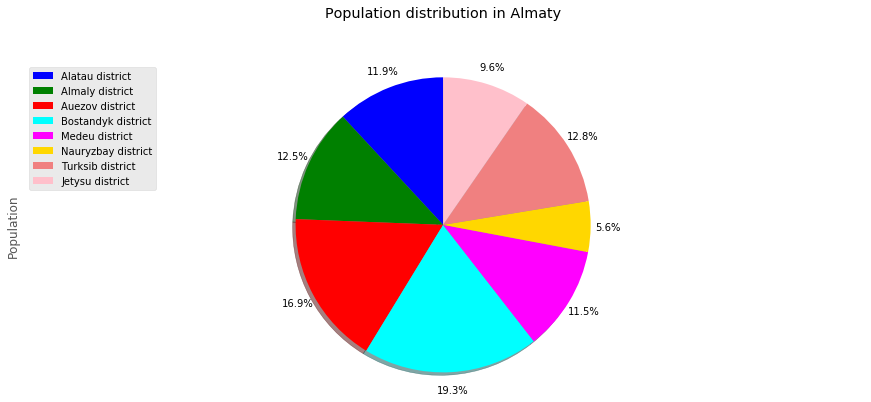

In [199]:
colors_list = ['blue','green','red','cyan','magenta','gold','lightcoral','pink']
df1['Population'].plot(kind='pie',figsize=(15,6),autopct='%1.1f%%',startangle=90,shadow=True,labels=None, pctdistance=1.12, colors=colors_list)
plt.title('Population distribution in Almaty',y=1.12)
plt.axis('equal')
plt.legend(labels=df1.index,loc='upper left')
plt.show()

### 2. Avg House Price and Population Density Dependancy

In [200]:
df2=almaty_merged[['Borough','Avg-House-SQR_M-Price-USD']]
df2.set_index('Borough', inplace=True)
df2

,Avg-House-SQR_M-Price-USD
Borough,
Alatau district,874
Almaly district,1048
Auezov district,929
Bostandyk district,1172
Medeu district,1337
Nauryzbay district,841
Turksib district,778
Jetysu district,836


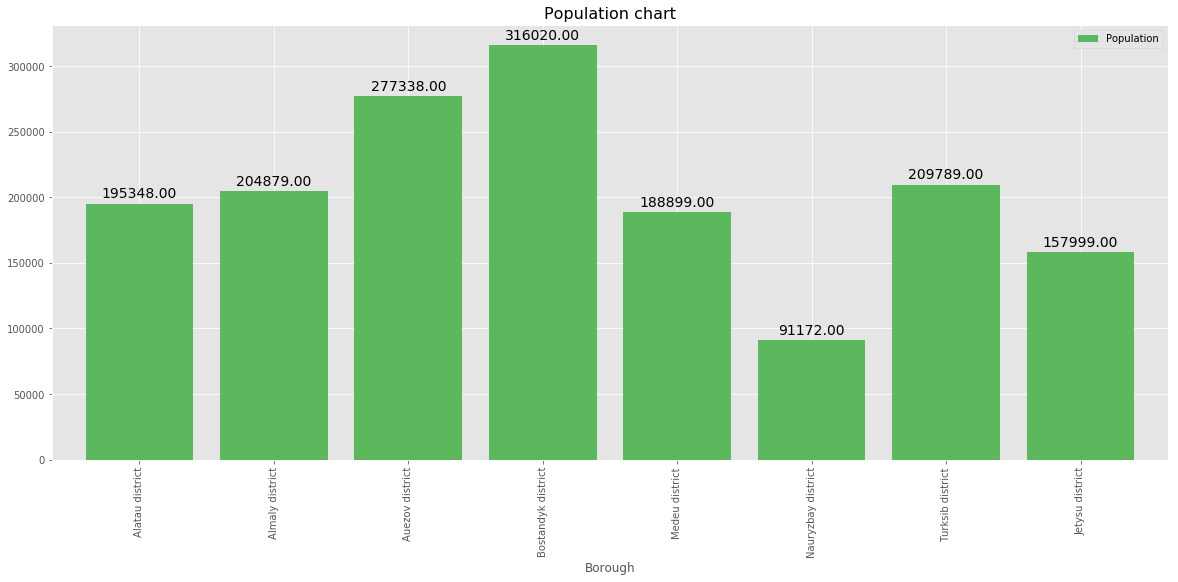

In [212]:
ax=df1.plot(kind='bar', figsize=(20, 8), width=0.8, color=['#5cb85c'], fontsize=10)
plt.title('Population chart', fontsize=16) # add title to the plot
#plt.legend(labels=df2.index, loc='upper right', fontsize=14) # add legend
for p in ax.patches:
  ax.annotate("%.2f" % p.get_height(),
    (p.get_x() + p.get_width()/2., p.get_height()),
    ha='center',
    va='center',
    xytext=(0, 10),
    textcoords='offset points',
    fontsize=14)
plt.show()


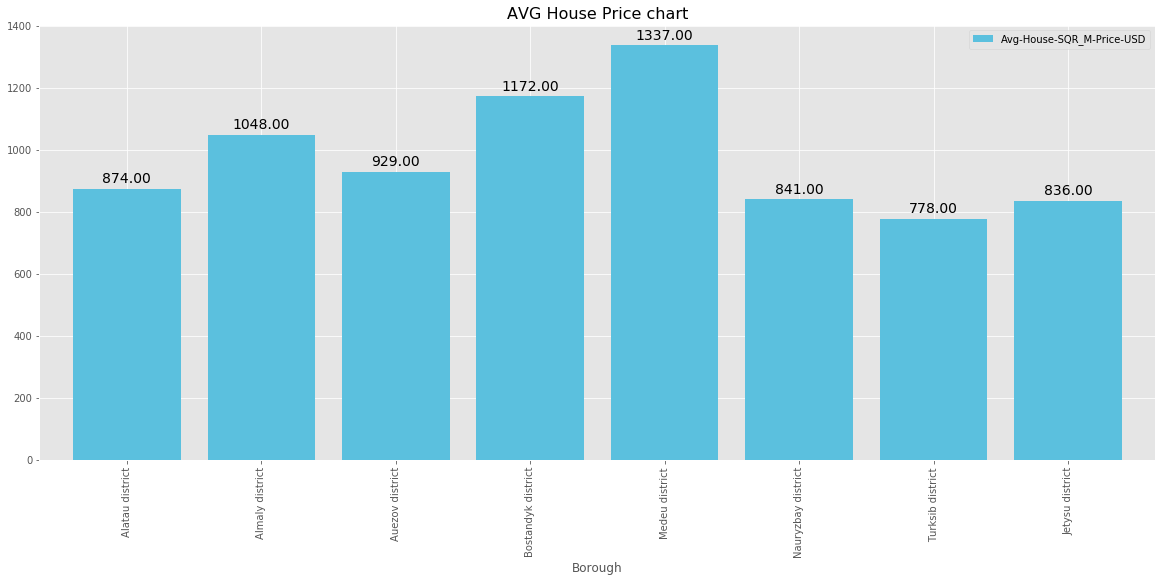

In [213]:
ax=df2.plot(kind='bar', figsize=(20, 8), width=0.8, color=['#5bc0de'], fontsize=10)
plt.title('AVG House Price chart', fontsize=16) # add title to the plot
#plt.legend(labels=df2.index, loc='upper right', fontsize=14) # add legend
for p in ax.patches:
  ax.annotate("%.2f" % p.get_height(),
    (p.get_x() + p.get_width()/2., p.get_height()),
    ha='center',
    va='center',
    xytext=(0, 10),
    textcoords='offset points',
    fontsize=14)
plt.show()

In [207]:
df3=almaty_merged[['Borough','Density-of-population-per-square_km']]
df3.set_index('Borough', inplace=True)
df3

,Density-of-population-per-square_km
Borough,
Alatau district,11152
Almaly district,1877
Auezov district,11754
Bostandyk district,3179
Medeu district,746
Nauryzbay district,1308
Turksib district,2783
Jetysu district,4001


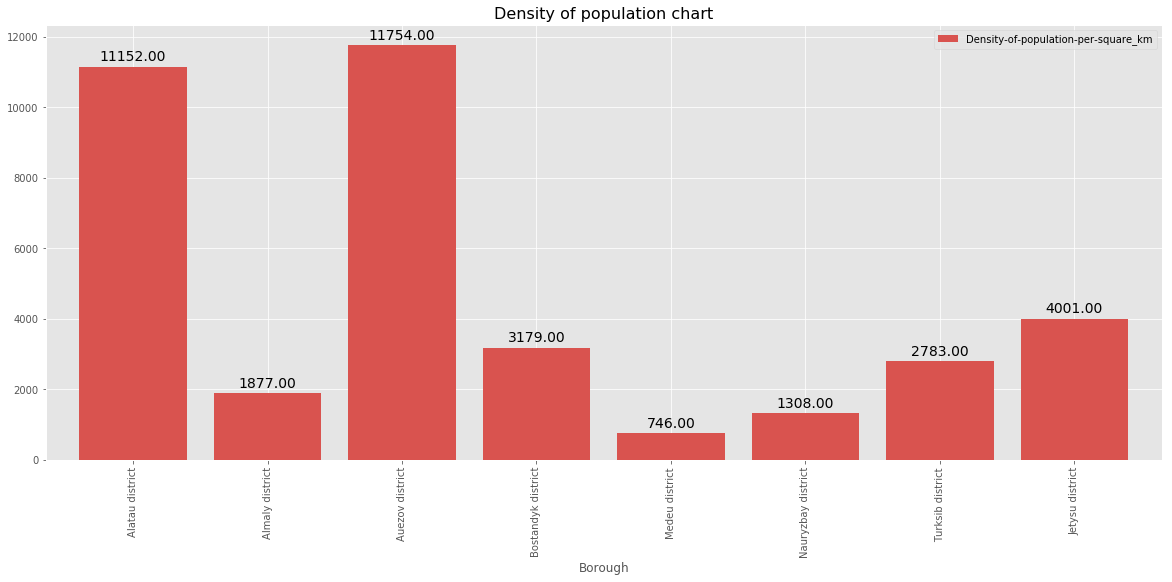

In [214]:
ax=df3.plot(kind='bar', figsize=(20, 8), width=0.8, color=['#d9534f'], fontsize=10)
plt.title('Density of population chart', fontsize=16) # add title to the plot
#plt.legend(labels=df2.index, loc='upper right', fontsize=14) # add legend
for p in ax.patches:
  ax.annotate("%.2f" % p.get_height(),
    (p.get_x() + p.get_width()/2., p.get_height()),
    ha='center',
    va='center',
    xytext=(0, 10),
    textcoords='offset points',
    fontsize=14)
plt.show()

In [215]:
df4=almaty_merged[['Borough','Density-of-population-per-square_km','Avg-House-SQR_M-Price-USD']]
df4.set_index('Borough', inplace=True)
df4

,Density-of-population-per-square_km,Avg-House-SQR_M-Price-USD
Borough,,
Alatau district,11152,874
Almaly district,1877,1048
Auezov district,11754,929
Bostandyk district,3179,1172
Medeu district,746,1337
Nauryzbay district,1308,841
Turksib district,2783,778
Jetysu district,4001,836


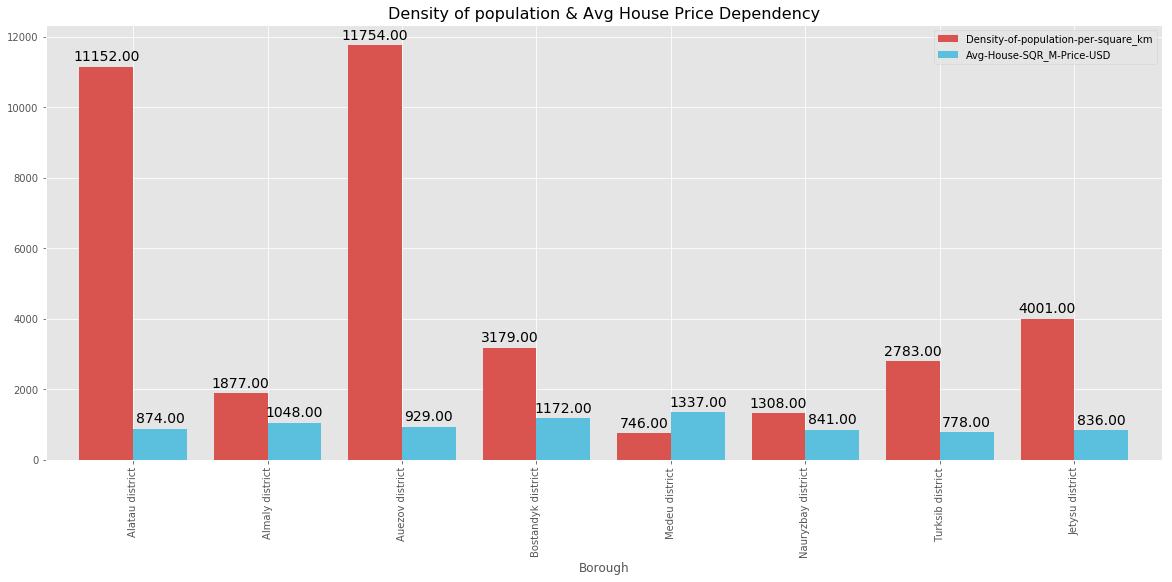

In [222]:
ax=df4.plot(kind='bar', figsize=(20, 8), width=0.8, color=['#d9534f','#5bc0de'], fontsize=10)
plt.title('Density of population & Avg House Price Dependency', fontsize=16) # add title to the plot
#plt.legend(labels=df2.index, loc='upper right', fontsize=14) # add legend
for p in ax.patches:
  ax.annotate("%.2f" % p.get_height(),
    (p.get_x() + p.get_width()/2., p.get_height()),
    ha='center',
    va='center',
    xytext=(0, 10),
    textcoords='offset points',
    fontsize=14)
plt.show()

## 5. Discussion section

As I mentioned before, Almaty is a big city with a high population density in a narrow area. The total number of measurements and population densities of the 8 districts in total can vary. As there is such a complexity, very different approaches can be tried in clustering and classification studies.

I used the Kmeans algorithm as part of this clustering study. For more detailed and accurate guidance, the data set can be expanded and the details of the neighborhood or street can also be drilled.

I also performed data analysis through this information by adding the coordinates of districts and home sales price averages as static data on GitHub.

I ended the study by visualizing the data and clustering information on the Almaty map. It could be used by city government and investors.

## 6. Conclusion section

As a result, people are turning to big cities to start a business or work. For this reason, people can achieve better outcomes through their access to the platforms where such information is provided.

Not only for investors but also city managers can manage the city more regularly by using similar data analysis types or platforms.

Thanks,
Alexey Startsev

## 7. References section

1.https://en.wikipedia.org/wiki/Almaty

2.https://journals.openedition.org/belgeo/28865?lang=en

3.https://developer.foursquare.com/

4.https://krisha.kz/content/analytics

5.https://www.google.com/maps/place/Almaty/@43.2178605,76.6639808,10z/data=!3m1!4b1!4m5!3m4!1s0x38836e7d16c5cbab:0x3d44668fad986d76!8m2!3d43.2220146!4d76.8512485

6.https://www.linkedin.com/pulse/housing-sales-prices-venues-data-analysis-ofistanbul-sercan-y%C4%B1ld%C4%B1z/